In [14]:
# !pip install -U ultralytics

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sort import *

In [2]:
class ObjectTracker:

    def __init__(self, model="yolov5"):
        # Model
        self.model_path = "../models/bags/farm_pipeline_0.1.pt"
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path)
        self.names = self.model.names
        self.model.conf=0.1

        #.... Initialize SORT .... 
        self.sort_max_age = 5 
        self.sort_min_hits = 2
        self.sort_iou_thresh = 0.2
        self.sort_tracker = Sort(max_age=self.sort_max_age,
                            min_hits=self.sort_min_hits,
                            iou_threshold=self.sort_iou_thresh) 
        self.track_color_id = 0

        ## Video Params
        self.video_path = '../videos/demo.mp4'
        self.cap = cv2.VideoCapture(self.video_path)
        self.frame_count = 0
        self.palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)
        if not self.cap.isOpened:
            print("Invalid Video.. Existing")
            exit(1)

        self.view_img = True
        self.color_box =False 

    def compute_color_for_labels(self, label):
        color = [int(int(p * (label ** 2 - label + 1)) % 255) for p in self.palette]
        return tuple(color)


    @staticmethod
    def bbox_rel(*xyxy):
        """" Calculates the relative bounding box from absolute pixel values. """

        bbox_left = min([xyxy[0].item(), xyxy[2].item()])
        bbox_top = min([xyxy[1].item(), xyxy[3].item()])
        bbox_w = abs(xyxy[0].item() - xyxy[2].item())
        bbox_h = abs(xyxy[1].item() - xyxy[3].item())
        x_c = (bbox_left + bbox_w / 2)
        y_c = (bbox_top + bbox_h / 2)
        w = bbox_w
        h = bbox_h
        return x_c, y_c, w, h


    """Function to Draw Bounding boxes"""
    def draw_boxes(self, img, bbox, identities=None, categories=None, 
                    names=None, color_box=None,offset=(0, 0)):
        for i, box in enumerate(bbox):
            x1, y1, x2, y2 = [int(i) for i in box]
            x1 += offset[0]
            x2 += offset[0]
            y1 += offset[1]
            y2 += offset[1]
            cat = int(categories[i]) if categories is not None else 0
            id = int(identities[i]) if identities is not None else 0
            data = (int((box[0]+box[2])/2),(int((box[1]+box[3])/2)))
            label = str(id)

            if color_box:
                color = self.compute_color_for_labels(id)
                (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                cv2.rectangle(img, (x1, y1), (x2, y2),color, 2)
                cv2.rectangle(img, (x1, y1 - 20), (x1 + w, y1), (255,191,0), -1)
                cv2.putText(img, label, (x1, y1 - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                [255, 255, 255], 1)
                cv2.circle(img, data, 3, color,-1)
            else:
                (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                cv2.rectangle(img, (x1, y1), (x2, y2),(255,191,0), 2)
                cv2.rectangle(img, (x1, y1 - 20), (x1 + w, y1), (255,191,0), -1)
                cv2.putText(img, label, (x1, y1 - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                [255, 255, 255], 1)
                cv2.circle(img, data, 3, (255,191,0),-1)
        return img


    def visualize(self, frame, tracked_dets, tracks):

        #loop over tracks
        for track in tracks:
            if self.color_box:
                color = self.compute_color_for_labels(track_color_id)
                [cv2.line(frame, (int(track.centroidarr[i][0]),int(track.centroidarr[i][1])), 
                        (int(track.centroidarr[i+1][0]),int(track.centroidarr[i+1][1])),
                        color, thickness=3) for i,_ in  enumerate(track.centroidarr) 
                        if i < len(track.centroidarr)-1 ] 
                track_color_id = track_color_id+1
            else:
                [cv2.line(frame, (int(track.centroidarr[i][0]),int(track.centroidarr[i][1])), 
                        (int(track.centroidarr[i+1][0]),int(track.centroidarr[i+1][1])),
                        (124, 252, 0), thickness=3) for i,_ in  enumerate(track.centroidarr) 
                        if i < len(track.centroidarr)-1 ] 

        # draw boxes for visualization
        if len(tracked_dets)>0:
            bbox_xyxy = tracked_dets[:,:4]
            identities = tracked_dets[:, 8]
            categories = tracked_dets[:, 4]
            self.draw_boxes(frame,
                            bbox_xyxy,
                            identities,
                            categories,
                            self.names,
                            self.color_box)

        return frame


    def run(self):
        
        frame_count = 0

        while True:
            ret, frame = self.cap.read()
            
            # Break the loop if there are no more frames
            if not ret:
                print("End of video or error occurred.")
                break
            
            # Increment the frame count
            frame_count += 1

            preds = self.model(frame)
            dets_to_sort = np.empty((0,6))
            for pred in preds.xyxy:
                for x1,y1,x2,y2,conf,detclass in pred.cpu().detach().numpy():
                    dets_to_sort = np.vstack(
                        (
                            dets_to_sort, 
                            np.array([x1, y1, x2, y2, conf, detclass])
                        )
                    )

            # Run SORT
            tracked_dets = self.sort_tracker.update(dets_to_sort)
            tracks = self.sort_tracker.getTrackers()
            frame = self.visualize(frame, tracked_dets, tracks)
        
            if self.view_img:
                cv2.imshow(str("sa"), frame)
                cv2.waitKey(1) 


            

        # Release the video capture object and close all OpenCV windows
        self.cap.release()
        cv2.destroyAllWindows()

            
        


In [ ]:
objecttracker = ObjectTracker()

In [ ]:
objecttracker.run()

In [ ]:
import inference

In [1]:
import cv2

# Open the video file
video_path = '../videos/demo.mp4'
cap = cv2.VideoCapture(video_path)

# Initialize frame count
frame_count = 0

while cap.isOpened() and frame_count < 50:
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if there are no frames left to read

    # Process the frame (for example, display it

    # Increment the frame count
    frame_count += 1

In [72]:
"""Object detector and Tracker """
import cv2
import torch
import numpy as np
import warnings
import torchvision
import torch.nn.functional as F
warnings.filterwarnings('ignore')

from sort import *


class ZoneDetector:

    def __init__(self, model="yolov5"):
        # Model
        self.model_path = "../models/segment/yolov5s_50_03.pt"
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=self.model_path)
        self.names = self.model.names
        self.model.conf=0.1
        # self.model.to("mps")
        self.stride = self.model.stride
        self.names = self.model.names

        self.im0 = None

    def xywh2xyxy(self, x):
        """Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right."""
        y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
        y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
        y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
        y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
        y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
        return y

    def box_iou(self, box1, box2, eps=1e-7):
        # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
        """
        Return intersection-over-union (Jaccard index) of boxes.

        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.

        Arguments:
            box1 (Tensor[N, 4])
            box2 (Tensor[M, 4])

        Returns:
            iou (Tensor[N, M]): the NxM matrix containing the pairwise
                IoU values for every element in boxes1 and boxes2
        """
        # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
        (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
        inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

        # IoU = inter / (area1 + area2 - inter)
        return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

    def non_max_suppression(
        self,
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
    ):
        """
        Non-Maximum Suppression (NMS) on inference results to reject overlapping detections.

        Returns:
            list of detections, on (n,6) tensor per image [xyxy, conf, cls]
        """
        # Checks
        assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
        if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
            prediction = prediction[0]  # select only inference output

        device = prediction.device
        mps = "mps" in device.type  # Apple MPS
        if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
            prediction = prediction.cpu()
        bs = prediction.shape[0]  # batch size
        nc = prediction.shape[2] - nm - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        # min_wh = 2  # (pixels) minimum box width and height
        max_wh = 7680  # (pixels) maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 0.5 + 0.05 * bs  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        mi = 5 + nc  # mask start index
        output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
        for xi, x in enumerate(prediction):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence

            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                lb = labels[xi]
                v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
                v[:, :4] = lb[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box/Mask
            box = self.xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
            mask = x[:, mi:]  # zero columns if no masks

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
            else:  # best class only
                conf, j = x[:, 5:mi].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            i = i[:max_det]  # limit detections
            if merge and (1 < n < 3e3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = self.box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            if mps:
                output[xi] = output[xi].to(device)
            if (time.time() - t) > time_limit:
                print(f"WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded")
                break  # time limit exceeded

        return output

    def crop_mask(self, masks, boxes):
        """
        "Crop" predicted masks by zeroing out everything not in the predicted bbox. Vectorized by Chong (thanks Chong).

        Args:
            - masks should be a size [n, h, w] tensor of masks
            - boxes should be a size [n, 4] tensor of bbox coords in relative point form
        """
        n, h, w = masks.shape
        x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(1,1,n)
        r = torch.arange(w, device=masks.device, dtype=x1.dtype)[None, None, :]  # rows shape(1,w,1)
        c = torch.arange(h, device=masks.device, dtype=x1.dtype)[None, :, None]  # cols shape(h,1,1)

        return masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))

    def process_mask(self, protos, masks_in, bboxes, shape, upsample=False):
        """
        Crop before upsample.
        proto_out: [mask_dim, mask_h, mask_w]
        out_masks: [n, mask_dim], n is number of masks after nms
        bboxes: [n, 4], n is number of masks after nms
        shape:input_image_size, (h, w).

        return: h, w, n
        """
        c, mh, mw = protos.shape  # CHW
        ih, iw = shape
        masks = (masks_in @ protos.float().view(c, -1)).sigmoid().view(-1, mh, mw)  # CHW

        downsampled_bboxes = bboxes.clone()
        downsampled_bboxes[:, 0] *= mw / iw
        downsampled_bboxes[:, 2] *= mw / iw
        downsampled_bboxes[:, 3] *= mh / ih
        downsampled_bboxes[:, 1] *= mh / ih

        masks = self.crop_mask(masks, downsampled_bboxes)  # CHW
        if upsample:
            masks = F.interpolate(masks[None], shape, mode="bilinear", align_corners=False)[0]  # CHW
        return masks.gt_(0.5)

    def clip_boxes(self, boxes, shape):
        """Clips bounding box coordinates (xyxy) to fit within the specified image shape (height, width)."""
        if isinstance(boxes, torch.Tensor):  # faster individually
            boxes[..., 0].clamp_(0, shape[1])  # x1
            boxes[..., 1].clamp_(0, shape[0])  # y1
            boxes[..., 2].clamp_(0, shape[1])  # x2
            boxes[..., 3].clamp_(0, shape[0])  # y2
        else:  # np.array (faster grouped)
            boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
            boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

    def scale_boxes(self, img1_shape, boxes, img0_shape, ratio_pad=None):
        """Rescales (xyxy) bounding boxes from img1_shape to img0_shape, optionally using provided `ratio_pad`."""
        if ratio_pad is None:  # calculate from img0_shape
            gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
            pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
        else:
            gain = ratio_pad[0][0]
            pad = ratio_pad[1]

        boxes[..., [0, 2]] -= pad[0]  # x padding
        boxes[..., [1, 3]] -= pad[1]  # y padding
        boxes[..., :4] /= gain
        self.clip_boxes(boxes, img0_shape)
        return boxes

    def preprocess(self, im0):
        self.im0 = im0
        im = cv2.resize(self.im0, (640, 384))
        im = np.transpose(im, (2, 0, 1))

        im = torch.from_numpy(im).to(self.model.device)
        im = im.half() if self.model.fp16 else im.float()  # uint8 to fp16/32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim

        return im
    
    def inference(self, image):
        im = self.preprocess(image)
        pred, proto = self.model(im)[:2]
        pred = self.non_max_suppression(pred,
                           conf_thres=0.1,
                           iou_thres=0.45,
                           classes=None, 
                           agnostic=False,
                           max_det=1000,
                           nm=32)
        
        # Process predictions
        for i, det in enumerate(pred):  # per image
            if len(det):
                masks = self.process_mask(proto[i], det[:, 6:], det[:, :4], im.shape[2:], upsample=True)  # HWC
                det[:, :4] = self.scale_boxes(im.shape[2:], det[:, :4], self.im0.shape).round()  # rescale boxes to im0 size
        
        masks = np.transpose(masks.numpy(), (1, 2, 0))
        binary_mask = (masks > 0).max(axis=-1).astype(np.uint8)  # Convert to 2D binary mask
        return binary_mask

            
if __name__ == "__main__":
    zone_detector = ZoneDetector()
    img = cv2.imread("test.jpg")
    binary_mask = zone_detector.inference(img)
    print("Mask Shape ", binary_mask)

Using cache found in /Users/rahul/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-3 Python-3.9.20 torch-2.5.0 CPU

Fusing layers... 
Model summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
WARNING ⚠️ YOLOv5 SegmentationModel is not yet AutoShape compatible. You will not be able to run inference with this model.


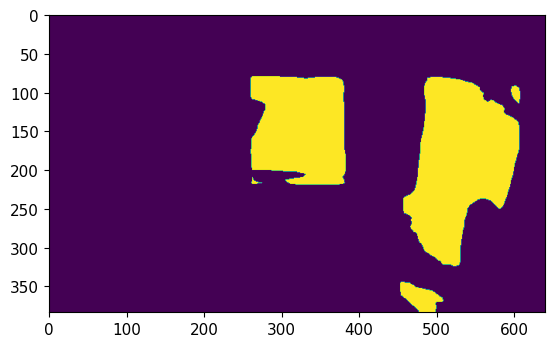

In [76]:
plt.imshow(binary_mask)